In [20]:
import os
import sys
import pandas as pd
import numpy as np
import xml.etree.cElementTree as ET
import matplotlib.pyplot as plt
from pandas.tseries.offsets import * # time series
%matplotlib inline

In [2]:
path = 'c:\\GITHUB\\SCOT_ATC\\dat\\'

In [3]:
# element tree of trips (no.xml extension as we are reserving that for loop through tripinfo.xml) at path
atcele = ET.parse(path+'sim\\base\\e1output.xml')
atcroot = atcele.getroot()

## define empty list
atc = []

In [4]:
## loop through xml finding all attribs and set data type
for s in atcroot.findall('interval'):
    aid = str(s.get('id'))
    sta = float(s.get('begin'))
    end = float(s.get('end'))
    nv = int(s.get('nVehContrib'))
    atc.append([aid,sta,end,nv]); ## append loop to list
    
atc = pd.DataFrame(atc)## pandas can convert a flat list or 2-d array to DataFrame
atc.columns = ['id', 'sta', 'end', 'Mcount'] # rename columns

In [5]:
# split detector_lane field to 2
df = pd.DataFrame(atc['id'].str.split('_',1).tolist(),columns=['detector', 'lane'], index=atc.index)

In [6]:
# merge DF to one
out = df.merge(atc, how='inner', left_index=True, right_index=True)
out.drop('id', axis=1, inplace=True)

In [7]:
mod = out.groupby(by='detector', axis=0).sum()
mod[:2]

,sta,end,Mcount
detector,,,
108502,561600,649402,195
108690,561600,649402,547


### Read ATC data

In [8]:
# list files
cs = os.listdir(path+'atc')
cs = cs[:-1]
cs[:2]

['108502.csv', '108690.csv']

In [9]:
ids = [x.split('.')[0] for x in cs]

In [10]:
ATC_C = pd.DataFrame(index=ids, columns=['Avg', 'Std'])
ATC_C[:2]

,Avg,Std
108502,NaN,NaN
108690,NaN,NaN


In [11]:
def ATC_DF(file_name, atc_id):
    global ATC_C
    # read DF
    df = pd.read_csv(path+'atc\\'+file_name, header=0, sep=',', parse_dates={"DTime" : [4,5]})
    df.DTime = pd.to_datetime(df['DTime'], format='%d%b%Y %H:%M')
    df.set_index('DTime', inplace=True)
    df = df.asfreq('1H', method=None)
    
    # drop cols if unamed and list cols with ATC data (CC)
    ccols = []
    for c in df.columns:
        if "Unname" in c:
            df.drop(c, axis=1, inplace=True)
        if "CC" in c:
            ccols.append(c)
        
    # subset
    df['Sum'] = df[ccols].sum(axis=1)
    df = df['Sum']

    # AM hours only
    df = df[(df.index.hour >= 4) & (df.index.hour <= 10)]
    # AM hours as 1 days
    df = df.resample('1d', how='sum')
    # AM weekdays only
    df = df.asfreq(BDay())
        
    ATC_C['Avg'].ix[atc_id] = df.mean()
    ATC_C['Std'].ix[atc_id] = df.std()
    return ATC_C

In [12]:
for fn,fid in zip(cs, ids):
    #print fid
    ATC_DF(fn, fid)

### Merge

In [13]:
mod[:2]

,sta,end,Mcount
detector,,,
108502,561600,649402,195
108690,561600,649402,547


In [14]:
ATC_C[:2]

,Avg,Std
108502,497.473,292.359
108690,1283.1,459.68


In [40]:
comp = mod.merge(ATC_C, how='inner', left_index=True, right_index=True)
n, mx = comp.ix[:,'Mcount':'Avg'].min()[0], comp.ix[:,'Mcount':'Avg'].max()[1] # get min,max for nomalisation
comp['Mcnorm'] = (comp['Mcount'] - mn) / (mx - mn) # normed values
comp['Anorm'] = (comp['Avg'] - mn) / (mx - mn) # normed values
comp['dif'] = comp['Avg'] - comp['Mcount'] # compute differences
comp['SQdif'] = np.square(comp['dif']) # compute sq difs
comp['Ndif'] = comp['Anorm'] - comp['Mcnorm'] # compute differences
comp['SQNdif'] = np.square(comp['Ndif']) # compute sq difs
comp[:2]

,sta,end,Mcount,Avg,Std,Mcnorm,Anorm,dif,SQdif,Ndif,SQNdif
108502,561600,649402,195,497.473,292.359,0.013848,0.0465712,302.473,91489.7,0.0327234,0.00107082
108690,561600,649402,547,1283.1,459.68,0.051929,0.131565,736.096,541838,0.0796355,0.0063418


In [41]:
RMSE = np.sqrt(comp['SQNdif'].sum() / len(comp))
RMSE

0.12113544593437915

In [81]:
x = range(1, 36)
len(x), len(comp['Mcnorm'])

(35, 35)

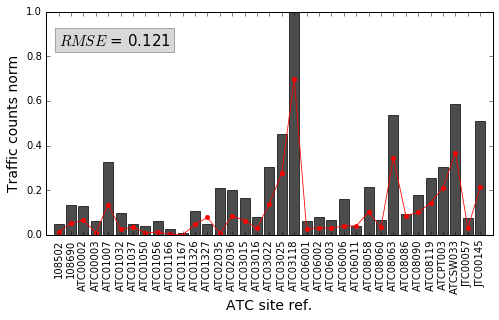

In [135]:
fig = plt.figure(figsize=(8,4))
ax1 = plt.subplot(111)

ax1.bar(x, comp['Anorm'], color='black', align='center', alpha=0.7)
ax1.plot(x, comp['Mcnorm'], color='red', marker='.', markersize=9, linestyle='-', linewidth=0.8)
ax1.set_xticks(x);
ax1.set_xticklabels(ids, rotation=90);
ax1.set_xlim(0,36)
ax1.set_ylabel('Traffic counts norm', fontsize=14)
ax1.set_xlabel('ATC site ref.', fontsize=14)
ax1.text(1,0.85, '$RMSE$ = %.3f' %RMSE, fontsize = 15, bbox=dict(facecolor='grey', alpha=0.3))

fig.savefig('c://GITHUB//SCOT_ATC//RMSE_base.png', dpi=400)